# Metin Oluşturucu Modelin Optimize Edilmesi

Yeni şarkılar üretme konusunda zaten bazı harika işler yaptık, ancak şu ana kadar tekrarlama ve makul miktarda tutarsızlık ile ilgili bazı sorunlar gördük. Daha fazla veri kullanarak ve modelde daha fazla ince ayar yaparak daha iyi sonuçlar elde edebileceksiniz. Burada bir kez daha [Kaggle Şarkı Sözleri Veri Kümesini]((https://www.kaggle.com/mousehead/songlyrics)) kullanacağız.

# TensorFlow ve Bazı Gerekli Paketlerin İçeri Aktarılması

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Veri ön işleme için içeri aktarmalar
import string
import numpy as np
import pandas as pd

## Veri Setinin Alınması


In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2021-07-28 21:03:22--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 142.250.141.139, 142.250.141.113, 142.250.141.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/72bgaatjsrk0trjoee63g7ms9vis79rq/1627506150000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2021-07-28 21:03:25--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/72bgaatjsrk0trjoee63g7ms9vis79rq/1627506150000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|1

## 250 Şarkı Sözü Alalım

Şimdi, sadece küçük bir şarkı örneği üzerinde eğitilmiş bir modelin, yeni metin üretmeye çalışırken ilerledikçe nasıl tekrarlamaya yol açtığını gördük. Bunun yerine 250 şarkıyı kullanmaya geçelim ve çıktımızın iyileşip iyileşmediğine bakalım. Bu aslında yaklaşık 10 bin satırlık şarkı sözü olacak, bu da yeterli olacaktır.

Oldukça fazla RAM ve işlem süresi alacağı için burada tam veri kümesini kullanmayacağımızı unutmayın, ancak bunu daha sonra kendi başınıza yapmayı deneyebilirsiniz. İlgileniyorsanız, muhtemelen Tokenizer için işlem süresini ve gereken belleği küçültmeye yardımcı olacak daha yaygın sözcüklerden yalnızca bazılarını kullanmak isteyeceksiniz (ya da yüz binlerce sözcük uzunluğunda bir çıktı diziniz olurdu).


In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Tokenize ediciyi yerleştirin
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Diğer tüm noktalama işaretlerini kaldır
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # küçük harf yap
  dataset[field] = dataset[field].str.lower()
  # Satıra göre bölmek için uzun bir dize yapın
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Sondaki boşlukları kaldırın
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Boş satırları kaldırın
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Tokenize ediciyi yerleştirin
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Veri setini csv'den okuyun - bu sefer 250 şarkı ile
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Şarkı sözlerini içeren 'metin' sütununu kullanarak göve metni oluşturun
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize edin
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# Şimdi çok daha fazla kelime olmalı
print(total_words)

2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Dizilerin ve Etiketlerin Oluşturulması

In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Eşit giriş uzunluğu için dolgu dizileri
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Giriş dizisi ve çıkış tahmin edilen kelime arasında dizileri bölün
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# Etiketler için one-hot kodlama yapın
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

## Daha İyi Bir Metin Oluşturma Modeli İnşa Edin

Daha fazla veriyle, sizi bütün gün burada tutmamak için 100 çağdan sonra keseceğiz. Ayrıca, henüz yapmadıysanız, çalışma zamanı türünüzü GPU olarak değiştirmek isteyeceksiniz (çalışma zamanlarını değiştirirseniz yukarıdaki hücreleri yeniden çalıştırmanız gerekecektir).


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 21s 8ms/step - loss: 5.9786 - accuracy: 0.0467
Epoch 2/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.6719 - accuracy: 0.0510
Epoch 3/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.4687 - accuracy: 0.0691
Epoch 4/100
1480/1480 [==============================] - 13s 9ms/step - loss: 5.2788 - accuracy: 0.0968
Epoch 5/100
1480/1480 [==============================] - 13s 8ms/step - loss: 5.0843 - accuracy: 0.1193
Epoch 6/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.8925 - accuracy: 0.1385
Epoch 7/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.7284 - accuracy: 0.1551
Epoch 8/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.5850 - accuracy: 0.1690
Epoch 9/100
1480/1480 [==============================] - 13s 9ms/step - loss: 4.4586 - accuracy: 0.1820
Epoch 10/100
1480/1480 [==============================] - 13s 9m

## Eğitim Grafiğinin Oluşturulması

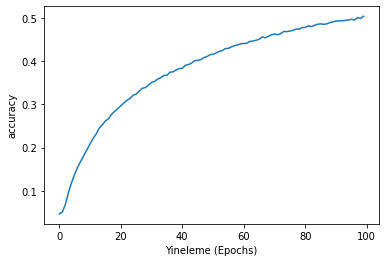

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Yineleme (Epochs)")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

## Daha İyi Şarkı Sözleri Oluşturalım

Bu sefer daha az tekrarla daha ilginç bir çıktı elde edebilmeliyiz.

In [8]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills to the road when you see the light there for you can get ahha ahha ahha ahha course lovin you are driving you and your shoes on each home last night lovin a spotlight of nights without you let me see a lot of mind we slack from sight circle of a sky i can do flies much and now i can share every shake with emotion songs that this else has got the bars to hide the reason melody can you loveland forever shine you go how gone dry aint got a little love is more loud and make


## Olası Çıktıların Değiştirilmesi

Yukarıdakileri çalıştırırken, aynı tohum metninin benzer çıktılar üreteceğini fark edebilirsiniz. Bunun nedeni, kodun şu anda her zaman bir sonraki kelime olarak tahmin edilen en yüksek sınıfı seçmesidir. Ya çıktıda daha fazla varyans istiyorsak?

`model.predict_classes` argümanından `model.predict_proba` seçeneğine geçmek bize tüm olasılıkları sağlayacaktır. Bir olasılığa dayalı olarak belirli bir tahmini çıktıyı seçmek için bunu `np.random.choice` ile birleştirebiliriz. Böylece çıktılarımıza biraz daha rastgelelik tanımlamış olacağız.

In [9]:
# Tohum metninden sonraki ilk kelimeyle yöntemi test edin
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Bu hücreyi birden çok kez çalıştırmak size çıktıda bir miktar farklılık sağlamalıdır.
print(predicted)

6


In [10]:
# Tam çıktı üretimi için bu işlemi kullanın
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills to see the answer to stay precious put making feelings to me paper under good sweet thunder keepin plane take this ready for you enough but i got to this money shed be through space and my heart can looks young and last night with you come caught in fire white side colour tried ad treasure hopes coward revelation helen ad rag gave foolish wellknown thunder hate lesson sitting questions joke nine to silly thunder soft spit images you see ya feeling down feeling sensible to leave it away hard to do then the heartaches he can make me sound
